In [43]:
%pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
import pandas as pd
import numpy as np
stations=pd.read_csv("data/stations.csv")
vehicles=pd.read_csv("data/vehicles.csv")
import random
import math

from deap import base, creator, tools
stations["cost"]=stations["cost"]

In [45]:
randomm =[np.random.rand() for i in range(stations["cost"].shape[0])]
stations["cost"]=stations["cost"]+randomm

In [46]:


# Define the problem parameters
car_locations= vehicles.values.copy()
station_locations= stations.values.copy()


# SPEA2

In [56]:

# Define the chromosome structure
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Define the genetic operators
def evaluate(individual):
    total_distance = 0
    total_cost = 0
    station_count = [0] * len(station_locations)
    for car_index, station_index in enumerate(individual):
        car_x, car_y = car_locations[car_index]
        station_x, station_y, station_price = station_locations[station_index]
        distance = math.sqrt((car_x - station_x) ** 2 + (car_y - station_y) ** 2)
        total_distance += distance
        total_cost += station_price
        station_count[station_index] += 1
    # Add constraint for maximum number of visits to a station
    for count in station_count:
        if count > 6:
            return total_distance+count,  total_cost+count    
    return total_distance, total_cost

def random_station():
    return random.randint(0, len(station_locations) - 1)

def mutation(individual):
    car_index = random.randint(0, len(individual) - 1)
    individual[car_index] = random_station()
    return individual,None

def crossover(parent1, parent2):
    cxpoint = random.randint(1, len(parent1) - 1)
    child1 = parent1[:cxpoint] + parent2[cxpoint:]
    child2 = parent2[:cxpoint] + parent1[cxpoint:]
    return creator.Individual(child1), creator.Individual(child2)

toolbox.register("evaluate", evaluate)
toolbox.register("individual", tools.initRepeat, creator.Individual, random_station, len(car_locations))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutation)
toolbox.register("select", tools.selSPEA2)#SPEA2
list_graph_SPEA2=[]
# Define the main function
def main():
    population_size = 100
    num_generations = 100
    cxpb = 0.5
    mutpb = 0.2
    # Create the initial population
    population = toolbox.population(n=population_size)
    
    
    # Evaluate the fitness of each individual in the population
    fitnesses = [toolbox.evaluate(individual) for individual in population]
    
    for individual, fitness in zip(population, fitnesses):  
        individual.fitness.values = fitness

    # Run the evolution
    for generation in range(num_generations):
        # Select the parents for the next generation
        
        offspring = toolbox.select(population,20# len(population)
                                  )

        # Apply crossover to create the children
        offspring = [toolbox.mate(parent1, parent2) for parent1, parent2 in zip(offspring[::2], offspring[1::2])]
        offspring = [child for pair in offspring for child in pair]

        # Apply mutation to create new individuals
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)

        # Evaluate the fitness of the new individuals
        #print(offspring)
        
        fitnesses = [toolbox.evaluate(individual) for individual in offspring]
        for individual, fitness in zip(offspring, fitnesses):
            individual.fitness.values = fitness

        # Combine the parents and children to create the next generation
        population[:] = toolbox.select(population + offspring, population_size)
        
        
        # Print the best individuals in the current generation
        best_individuals = tools.selBest(population, k=10)
        #print("Generation", generation)
        #for individual in best_individuals:
            #print("  Distance:", individual.fitness.values[0], "Cost:", individual.fitness.values[1], "Assignments:", individual)
        # extract Pareto front
        pareto_front = tools.sortNondominated(population, k=10, first_front_only=True)[0]
    print("Pareto Front de SPEA2:")
    unique_front=[]
    for individual in pareto_front:
        if individual not in unique_front:
            print("  Distance:", individual.fitness.values[0], "Cost:", individual.fitness.values[1], "Assignments:", individual)
            list_graph_SPEA2.append([individual.fitness.values[0],individual.fitness.values[1]])
            print("-----------------------------------------------------")

            unique_front.append(individual)
    #return offspring



main()

Pareto Front de SPEA2:
  Distance: 423.98474047439856 Cost: 77.78156441971304 Assignments: [90, 15, 38, 55, 22, 65, 65, 59, 61, 5, 47, 30, 90, 99, 30, 70, 99, 7, 36, 83, 45, 16, 12, 72, 95, 99, 79, 27, 83, 7, 38, 32, 61, 83, 7, 49, 60, 27, 24, 1, 94, 59, 42, 65, 94, 83, 77, 14, 26, 46, 62, 90, 83, 94, 91, 99, 46, 50, 82, 12, 27, 87, 95, 71, 51, 40, 54, 61, 59, 47, 42, 30, 5, 37, 61, 83, 12, 62, 23, 7, 55, 80, 30, 59, 38, 91, 69, 44, 91, 88, 96, 30, 43, 101, 35, 84, 43, 1, 38, 93, 22, 71]
-----------------------------------------------------
  Distance: 402.6846574423985 Cost: 82.06597644064077 Assignments: [90, 15, 38, 55, 22, 65, 65, 59, 61, 5, 47, 30, 90, 99, 30, 70, 99, 7, 36, 83, 45, 16, 30, 72, 95, 99, 79, 27, 83, 7, 38, 32, 32, 83, 7, 49, 101, 27, 24, 1, 94, 59, 42, 65, 94, 83, 77, 14, 26, 24, 62, 90, 83, 94, 91, 99, 46, 50, 82, 12, 27, 87, 95, 71, 51, 40, 54, 61, 59, 47, 42, 30, 5, 37, 61, 83, 12, 62, 23, 7, 55, 1, 95, 16, 98, 52, 60, 92, 78, 72, 96, 30, 43, 101, 35, 84, 43, 1, 

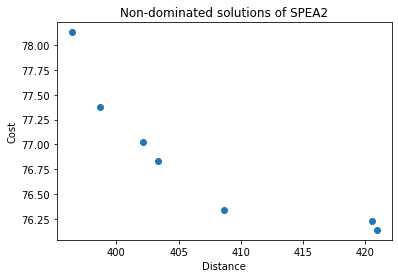

In [48]:
list_graph_SPEA2=np.array(list_graph_SPEA2)

import matplotlib.pyplot as plt

# Define the points
x= list_graph_SPEA2[:,0]
y= list_graph_SPEA2[:,1]


# Connect the points with a line
plt.plot(x, y, 'o')

# Add axis labels and title
plt.xlabel('Distance')
plt.ylabel('Cost')
plt.title('Non-dominated solutions of SPEA2')

# Show the plot
plt.show()

# NSGA2

In [49]:
# Define the chromosome structure
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox1 = base.Toolbox()

# Define the genetic operators
def evaluate(individual):
    
    total_distance = 0
    total_cost = 0
    station_count = [0] * len(station_locations)
    for car_index, station_index in enumerate(individual):
        car_x, car_y = car_locations[car_index]
        station_x, station_y, station_price = station_locations[station_index]
        distance = math.sqrt((car_x - station_x) ** 2 + (car_y - station_y) ** 2)
        total_distance += distance
        total_cost += station_price
        station_count[station_index] += 1
    # Add constraint for maximum number of visits to a station
    for count in station_count:
        if count > 6:
            return total_distance+count,  total_cost+count
    
    
    return total_distance, total_cost

def random_station():
    return random.randint(0, len(station_locations) - 1)

def mutation(individual):
    car_index = random.randint(0, len(individual) - 1)
    individual[car_index] = random_station()
    return individual,None

def crossover(parent1, parent2):
    cxpoint = random.randint(1, len(parent1) - 1)
    child1 = parent1[:cxpoint] + parent2[cxpoint:]
    child2 = parent2[:cxpoint] + parent1[cxpoint:]
    return creator.Individual(child1), creator.Individual(child2)

toolbox1.register("evaluate", evaluate)
toolbox1.register("individual", tools.initRepeat, creator.Individual, random_station, len(car_locations))
toolbox1.register("population", tools.initRepeat, list, toolbox.individual)
toolbox1.register("mate", crossover)
toolbox1.register("mutate", mutation)
toolbox1.register("select", tools.selNSGA2)
list_graph_NSGA2=[]
# Define the main function
def main():
    population_size = 100
    num_generations = 100
    cxpb = 0.5
    mutpb = 0.2
    # Create the initial population
    population = toolbox1.population(n=population_size)
    
    
    # Evaluate the fitness of each individual in the population
    fitnesses = [toolbox1.evaluate(individual) for individual in population]
    
    for individual, fitness in zip(population, fitnesses):  
        individual.fitness.values = fitness

    # Run the evolution
    for generation in range(num_generations):
        # Select the parents for the next generation
        
        offspring = toolbox1.select(population,20# len(population)
                                  )

        # Apply crossover to create the children
        offspring = [toolbox1.mate(parent1, parent2) for parent1, parent2 in zip(offspring[::2], offspring[1::2])]
        offspring = [child for pair in offspring for child in pair]

        # Apply mutation to create new individuals
        for mutant in offspring:
            if random.random() < mutpb:
                toolbox1.mutate(mutant)

        # Evaluate the fitness of the new individuals
        #print(offspring)
        
        fitnesses = [toolbox1.evaluate(individual) for individual in offspring]
        for individual, fitness in zip(offspring, fitnesses):
            individual.fitness.values = fitness

        # Combine the parents and children to create the next generation
        population[:] = toolbox1.select(population + offspring, population_size)
        
        
        # Print the best individuals in the current generation
        #best_individuals = tools.selBest(population, k=10)
        #print("Generation", generation)
        #for individual in best_individuals:
            #print("  Distance:", individual.fitness.values[0], "Cost:", individual.fitness.values[1], "Assignments:", individual)
        # extract Pareto front
        pareto_front = tools.sortNondominated(population, k=10, first_front_only=True)[0]
    print("Pareto Front with NSGA2:")
    unique_front=[]
    for individual in pareto_front:
        if individual not in unique_front:
            print("  Distance:", individual.fitness.values[0], "Cost:", individual.fitness.values[1], "Assignments:", individual)
            print("------------------------------------------------------------------------------------------------ n")
            unique_front.append(individual)
            list_graph_NSGA2.append([individual.fitness.values[0],individual.fitness.values[1]])

    return offspring

offspring=main()

Pareto Front with NSGA2:
  Distance: 394.00258092370746 Cost: 84.03932990269989 Assignments: [26, 7, 83, 15, 99, 1, 55, 58, 44, 95, 34, 28, 81, 68, 14, 1, 9, 42, 59, 9, 75, 91, 61, 43, 51, 39, 32, 7, 1, 17, 83, 4, 90, 3, 41, 67, 91, 90, 99, 71, 99, 28, 26, 30, 53, 49, 90, 60, 70, 20, 54, 65, 59, 59, 8, 55, 32, 83, 34, 62, 88, 0, 60, 20, 14, 13, 21, 59, 65, 41, 51, 54, 18, 35, 23, 65, 49, 65, 59, 95, 3, 12, 45, 80, 80, 49, 59, 90, 44, 65, 90, 7, 96, 38, 55, 65, 51, 42, 39, 51, 1, 71]
------------------------------------------------------------------------------------------------ n
  Distance: 435.60262005883817 Cost: 77.94096790295778 Assignments: [26, 7, 83, 15, 99, 1, 93, 58, 44, 95, 34, 28, 28, 68, 14, 1, 54, 42, 59, 9, 7, 91, 61, 43, 51, 39, 32, 7, 1, 17, 83, 69, 71, 36, 44, 76, 91, 90, 99, 71, 99, 28, 26, 30, 12, 40, 90, 60, 70, 20, 54, 65, 91, 51, 82, 60, 21, 83, 34, 62, 41, 0, 60, 15, 14, 11, 21, 59, 65, 41, 19, 54, 18, 35, 23, 65, 49, 65, 59, 95, 3, 12, 92, 80, 80, 49, 59, 90, 4

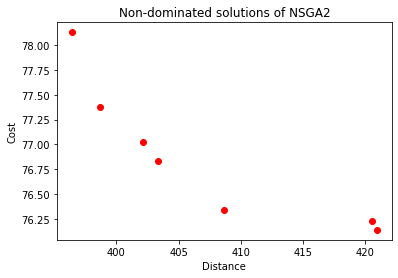

In [50]:
list_graph_NSGA2=np.array(list_graph_NSGA2)


# Define the points
x1= list_graph_SPEA2[:,0]
y1= list_graph_SPEA2[:,1]

# Connect the points with a line
plt.plot(x1, y1, 'o',color="r")

# Add axis labels and title
plt.xlabel('Distance')
plt.ylabel('Cost')
plt.title('Non-dominated solutions of NSGA2')

# Show the plot
plt.show()

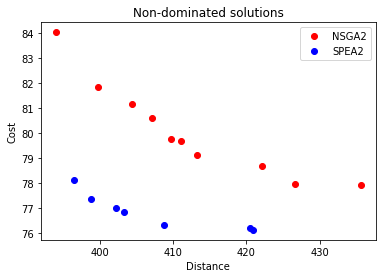

In [51]:



# Define the points
x= list_graph_NSGA2[:,0]
y= list_graph_NSGA2[:,1]



# Define the points
x1= list_graph_SPEA2[:,0]
y1= list_graph_SPEA2[:,1]



# Connect the points with a line
plt.plot(x, y, 'o',color="r")
plt.plot(x1, y1, 'o',color="b")

# Add axis labels and title
plt.xlabel('Distance')
plt.ylabel('Cost')
plt.legend(["NSGA2","SPEA2"])
plt.title('Non-dominated solutions')

# Show the plot
plt.show()